In [1]:
#Mounting the google drive so that the images can be added and accessed
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -qU openimages torch_snippets urllib3

In [3]:
!pip install lovely-tensors

In [4]:
#Importing the packages to fetch the JSON file contains about the image informations to download
!wget -O open_images_train_captions.jsonl -q https://storage.googleapis.com/localized-narratives/annotations/open_images_train_v6_captions.jsonl

In [5]:
# Import the relevant packages and defining the device
from torch_snippets import *
import json
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Running on device: ", device)

Running on device:  cuda

In [6]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

#Opening the JSON file
with open('open_images_train_captions.jsonl','r') as json_file:

    # Reading the file and split it into a list of JSON strings
    json_list = json_file.read().split("\n")

# Shuffle the list
np.random.shuffle(json_list)

# Creating an empty list to store the dataframes
data = []

# here we are defining the number of samples to use
N = 10000

# Iteraing over the JSON strings
for ix, json_str in tqdm(enumerate(json_list), total=N):
    if ix == N:
        break
    try:
        # Load the JSON string into a dictionary
        result = json.loads(json_str)
        # Converting the dictionary into a dataframe
        x = pd.DataFrame.from_dict(result, orient="index").T
        # Append the dataframe to the list
        data.append(x)
    except:
        pass

100%|██████████| 10000/10000 [00:06<00:00, 1555.33it/s]


In [7]:
x

,dataset_id,image_id,annotator_id,caption
0,open_images,6c37602428a5963a,72,In the center of the image we can see building...


In [8]:
result

{'dataset_id': 'open_images',
 'image_id': '6c37602428a5963a',
 'annotator_id': 72,
 'caption': 'In the center of the image we can see buildings with windows, door, roofs. The two covers are placed on the ground. On the left side of the image we can see a fence. In the background, we can see grass, a group of trees, plants, the sky and some text.'}

In [9]:
# Split the dataframe (data) into training and validation datasets
np.random.seed(10)

data = pd.concat(data)
data['train'] = np.random.choice([True,False], size=len(data),p=[0.95,0.05])
data.to_csv('data.csv', index=False)

In [10]:
import os

os.makedirs('./train-images/', exist_ok=True)
os.makedirs('./val-images/', exist_ok=True)


In [11]:
# Downloading images for training set and saving them in the directory
from openimages.download import _download_images_by_id

subset_imageIds = data[data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './train-images/')

subset_imageIds = data[~data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './val-images/')

100%|██████████| 470/470 [00:09<00:00, 51.88it/s]


In [12]:
!pip install torchtext

In [13]:
!pip install --upgrade torchtext

  Using cached torchtext-0.17.1-cp310-cp310-manylinux1_x86_64.whl (2.0 MB)
  Using cached torch-2.2.1-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Using cached torchdata-0.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.7 MB/s eta 0:00

In [14]:
pip install torchtext==0.6.0

  Using cached torchtext-0.6.0-py3-none-any.whl (64 kB)
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.17.1
    Uninstalling torchtext-0.17.1:
      Successfully uninstalled torchtext-0.17.1


In [15]:
!pip install pydot

In [16]:
#Creating a vocabulary of all the unique words present in all the captions in the dataframe:
# A vocabulary object is something that can map every word in all the captions to a unique integer and vice versa
from torchtext.data import Field
from pycocotools.coco import COCO
from collections import defaultdict

captions = Field(sequential=False, init_token='<start>', eos_token='<end>')

all_captions = data[data['train']]['caption'].tolist()
all_tokens = [[w.lower() for w in c.split()] for c in all_captions]
all_tokens = [w for sublist in all_tokens for w in sublist]

captions.build_vocab(all_tokens)

In [17]:
# Captioning the vocabulary components
class Vocab: pass

vocab = Vocab()
captions.vocab.itos.insert(0, '<pad>')
vocab.itos = captions.vocab.itos

vocab.stoi = defaultdict(lambda:captions.vocab.itos.index('<unk>'))
vocab.stoi['<pad>'] = 0

for s,i in captions.vocab.stoi.items():
    vocab.stoi[s] = i+1

In [18]:
# Dataset class
# Defining the dataset class – CaptioningDataset:
from torchvision import transforms

class CaptioningData(Dataset):
    def __init__(self, root, df, vocab):
        self.df = df.reset_index(drop=True)
        self.root = root
        self.vocab = vocab

        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
        )

    # Returns single data pair (image and caption)
    def __getitem__(self, index):
        row = self.df.iloc[index].squeeze()
        id = row.image_id

        image_path = f'{self.root}/{id}.jpg'
        image = Image.open(os.path.join(image_path)).convert('RGB')

        caption = row.caption

        tokens = str(caption).lower().split()
        target = []
        target.append(vocab.stoi['<start>'])
        target.extend([vocab.stoi[token] for token in tokens])
        target.append(vocab.stoi['<end>'])
        target = torch.Tensor(target).long()

        return image, target, caption

    def choose(self):
        return self[np.random.randint(len(self))]

    def __len__(self):
        return len(self.df)

    # Creates batch of captions and padds captions to be equal length
    def collate_fn(self, data):
        data.sort(key=lambda x: len(x[1]), reverse=True)
        images, targets, captions = zip(*data)
        images = torch.stack([self.transform(image) for image in images], 0)

        lengths = [len(tar) for tar in targets]
        _targets = torch.zeros(len(captions), max(lengths)).long()

        for i, tar in enumerate(targets):
            end = lengths[i]
            _targets[i, :end] = tar[:end]

        return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)

In [19]:
#Define the training and validation dataset and data loaders
trn_ds = CaptioningData('train-images', data[data['train']], vocab)

val_ds = CaptioningData('val-images', data[~data['train']], vocab)

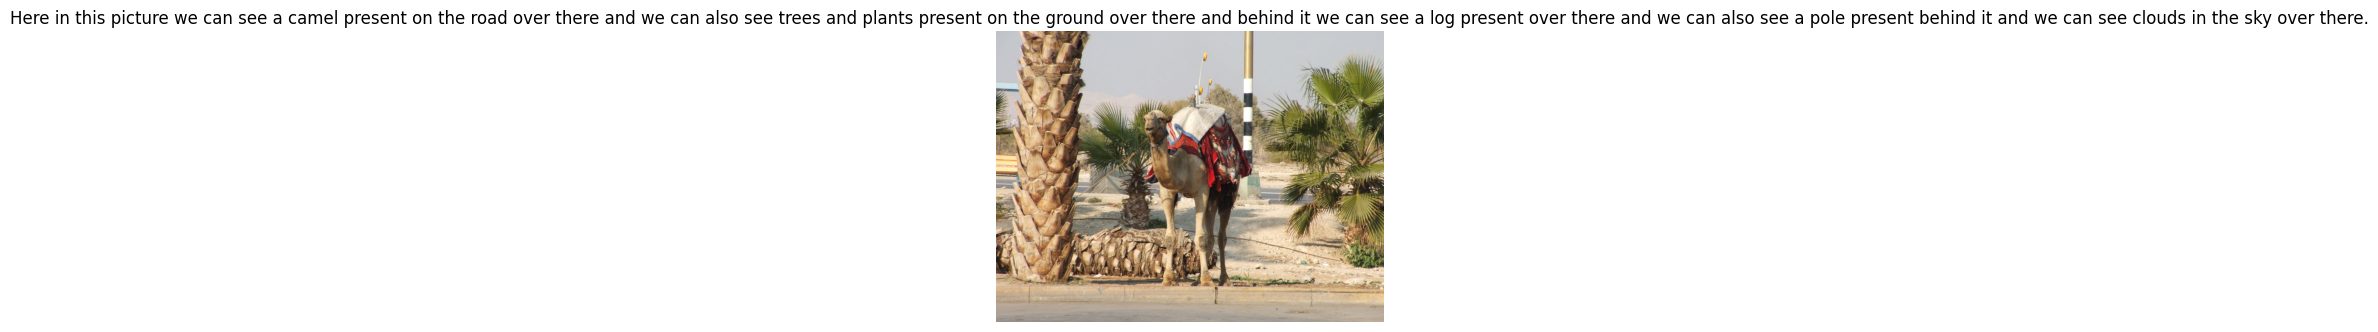

tensor[62] i64 x∈[2, 1923] μ=100.274 σ=315.759

In [20]:
# Show sample image and caption
image, target, caption = trn_ds.choose()
show(image, title=caption, sz=5); print(target)

In [21]:
# Create the dataloaders for the datasets
trn_dl = DataLoader(trn_ds, 32, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, collate_fn=val_ds.collate_fn)

In [22]:
!pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 8.7 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.2.0
    Uninstalling triton-2.2.0:
      Successfully uninstalled triton-2.2.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.19.3
    Uninstalling nvidia-nccl-cu12-2.19.3:
      Successfully uninstalled nvidia-nccl-cu12-2.19.3
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1
    Uninstalling torch-2.2.1:
      Successfully uninstalled torch-2.2.1


In [ ]:
!pip install torch_snippets

In [23]:
import torch
from torch_snippets import inspect

In [24]:
# A sample batch
import torch
inspect(*next(iter(trn_dl)), names='images,targets,lengths')

══════════════════════════════════════════════════════════════════

tensor[32, 3, 224, 224] n=4816896 (18Mb) x∈[-2.118, 2.640] μ=-0.219 σ=1.291 cuda:0

══════════════════════════════════════════════════════════════════

tensor[32, 95] i64 n=3040 (24Kb) x∈[0, 5629] μ=56.097 σ=298.966 cuda:0

══════════════════════════════════════════════════════════════════

tensor[32] i64 x∈[17, 95] μ=35.438 σ=16.679 cuda:0

══════════════════════════════════════════════════════════════════

In [25]:
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models
# Define the network class:
#Define the encoder architecture – EncoderCNN:

class EncoderCNN(nn.Module):

    # Load the pretrained ResNet-152 and replace top fc layer
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)

        # delete the last fc layer.
        modules = list(resnet.children())[:-1]

        # Connect it to a linear layer
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)

        # Pass it through batch normalization
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    # Extract feature vectors from input images
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)

        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))

        return features

In [26]:
# Fetch a summary of the encoder class:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = EncoderCNN(256).to(device)
print(summary(encoder, (3, 224, 224), device=device.type))

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 142MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

None

In [27]:
# Define the decoder architecture – DecoderRNN Class
class DecoderRNN(nn.Module):

    # Initialize the hyper-parameters and build the layers
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=80):

        super(DecoderRNN, self).__init__()

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length

    # Decode image feature vectors and generates captions
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)

        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True)

        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs[0])
        return outputs

    #Generate captions for given image features using greedy search
    def predict(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)

        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)

            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)

            sampled_ids.append(predicted)

            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)


        sampled_ids = torch.stack(sampled_ids, 1) # sampled_ids: (batch_size, max_seq_length)

        # convert predicted tokens to strings
        sentences = []
        for sampled_id in sampled_ids:
            sampled_id = sampled_id.cpu().numpy()
            sampled_caption = []

            for word_id in sampled_id:
                word = vocab.itos[word_id]
                sampled_caption.append(word)

                if word == '<end>':
                    break

            sentence = ' '.join(sampled_caption)
            sentences.append(sentence)

        return sentences

In [28]:
# Trains on a single batch of data
def train_batch(data, encoder, decoder, optimizer, criterion):
    encoder.train()
    decoder.train()

    images, captions, lengths = data
    images = images.to(device)

    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]

    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)

    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [29]:
# Validation on a batch of data
@torch.no_grad()
def validate_batch(data, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()

    images, captions, lengths = data
    images = images.to(device)

    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]

    features = encoder(images)
    outputs = decoder(features, captions, lengths)

    loss = criterion(outputs, targets)
    return loss

In [30]:
# Define encoder, decoder, loss function, and optimizer
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab.itos), 1).to(device)
criterion = nn.CrossEntropyLoss()

params = list(decoder.parameters()) + \
         list(encoder.linear.parameters()) + \
         list(encoder.bn.parameters())

optimizer = torch.optim.AdamW(params, lr=1e-3)



In [31]:
n_epochs = 5
log = Report(n_epochs)

EPOCH: 1.000  trn_loss: 3.315  val_loss: 2.728  (266.84s - 1067.37s remaining)
EPOCH: 2.000  trn_loss: 2.497  val_loss: 2.511  (516.31s - 774.47s remaining)
EPOCH: 3.000  trn_loss: 2.267  val_loss: 2.391  (765.07s - 510.05s remaining)
EPOCH: 4.000  trn_loss: 2.104  val_loss: 2.365  (1014.46s - 253.61s remaining)
EPOCH: 5.000  trn_loss: 2.070  val_loss: 2.359  (1262.91s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 1212.84it/s]


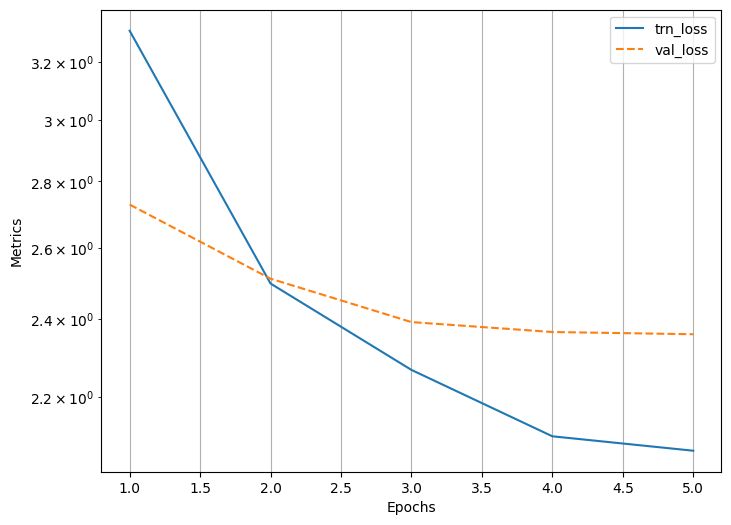

In [32]:
# Train the model over increasing epochs
for epoch in range(n_epochs):
    if epoch == 3: optimizer = torch.optim.AdamW(params, lr=1e-4)

    N = len(trn_dl)
    for i, data in enumerate(trn_dl):
        trn_loss = train_batch(data, encoder, decoder, optimizer, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, trn_loss=trn_loss, end='\r')

    N = len(val_dl)

    for i, data in enumerate(val_dl):
        val_loss = validate_batch(data, encoder, decoder, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, val_loss=val_loss, end='\r')

    log.report_avgs(epoch+1)

log.plot_epochs(log=True)

In [33]:
# Generates predictions given an image
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        tfm_image = transform(image)[None]

    return image, tfm_image

def load_image_and_predict(image_path):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                    ])

    org_image, tfm_image = load_image(image_path, transform)
    image_tensor = tfm_image.to(device)

    encoder.eval()
    decoder.eval()

    feature = encoder(image_tensor)
    sentence = decoder.predict(feature)[0]
    show(org_image, title=sentence)
    return sentence

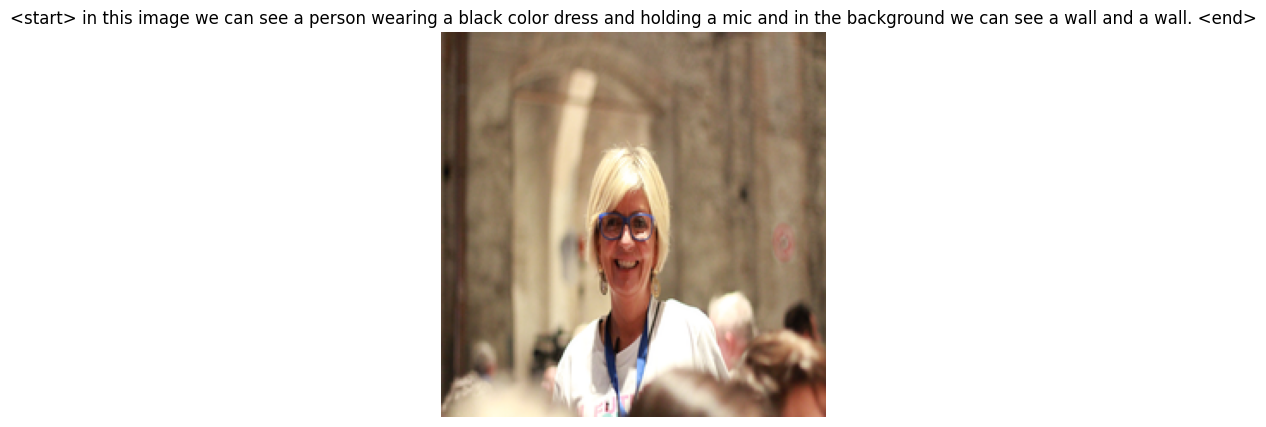

'<start> in this image we can see a person wearing a black color dress and holding a mic and in the background we can see a wall and a wall. <end>'

In [34]:
# Predict an image
files = Glob('val-images')
load_image_and_predict(choose(files))